## Uso de las vecotores con algoritmo de KNN 

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgb2gray
import json
import matplotlib.pyplot as plt

def load_features(output_dir):
    """
    Carga descriptores y mapeo desde archivos
    """
    descriptors = np.load(f"{output_dir}/descriptores.npy")
    with open(f"{output_dir}/checkpoint.json", 'r') as f:
        mapping = json.load(f)
    return descriptors, mapping


output_dir = "features"
descriptors, mapping = load_features(output_dir)


In [2]:
print("Descriptores cargados:")
print(f"- Total descriptores: {descriptors.shape[0]}")
print(f"- Dimensiones descriptores: {descriptors.shape[1]}")
print(f"- Mapeo de imágenes: {len(mapping)}")


Descriptores cargados:
- Total descriptores: 3587
- Dimensiones descriptores: 128
- Mapeo de imágenes: 3586


## Uso de KNN

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
from rtree import index
import numpy as np

# Métrica de distancia: Euclidiana
def euclidean_distance(P, Q):
    return np.sqrt(np.sum((P - Q) ** 2))

def create_rtree_index(descriptors):
    p = index.Property()
    p.dimension = 128  # Dimensión de los embeddings faciales
    idx = index.Index(properties=p)
    
    for i, descriptor in enumerate(descriptors):
        # Usamos cada dimensión como límite inferior y superior
        idx.insert(i, tuple(descriptor) + tuple(descriptor))
    return idx


# Búsqueda KNN usando R-Tree
def knn_rtree(query_vector, idx, descriptors, k=5):
    # Buscamos en el índice
    nearest_neighbors = list(idx.nearest(tuple(query_vector) + tuple(query_vector), k))
    # Retornamos los vecinos con sus distancias calculadas
    return [(i, euclidean_distance(query_vector, descriptors[i])) for i in nearest_neighbors]


In [8]:
def show_results(results, csv_file, query_idx, num_results=5):
    """
    Muestra imagen de consulta y resultados en formato horizontal (<= 5 resultados) 
    o en matriz (> 5 resultados)
    """
    df = pd.read_csv(csv_file)
    n_imgs = min(len(results), num_results)
    
    # Calcular disposición de la matriz si hay más de 5 resultados
    if n_imgs > 5:
        # Calcular número de filas y columnas para la matriz
        n_cols = 5  # Fijo 5 columnas
        n_rows = (n_imgs - 1) // n_cols + 1  # Calcular filas necesarias
        fig = plt.figure(figsize=(15, 3*n_rows))
    else:
        # Disposición horizontal para 5 o menos resultados
        fig = plt.figure(figsize=(15, 5))
    
    try:
        query_url = df.iloc[query_idx]['link']
        query_filename = df.iloc[query_idx]['filename']
        query_img = imread(query_url)
        
        # Crear subplot para la imagen de consulta
        if n_imgs > 5:
            plt.subplot(n_rows + 1, n_cols, 3)  # Centrar imagen de consulta
        else:
            plt.subplot(1, n_imgs + 1, 1)
        
        # Agregar borde rojo a la imagen de consulta
        plt.imshow(query_img)
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
        
        plt.title(f"Consulta:\n{query_filename}", fontsize=10)
        plt.axis('on')
        plt.xticks([])
        plt.yticks([])
        
        # Mostrar resultados
        for i, (idx, distance) in enumerate(results[:num_results]):
            try:
                image_url = df.iloc[idx]['link']
                filename = df.iloc[idx]['filename']
                img = imread(image_url)
                
                if n_imgs > 5:
                    # Crear subplot en formato matriz
                    plt.subplot(n_rows + 1, n_cols, n_cols + i + 1)
                else:
                    # Crear subplot horizontal
                    plt.subplot(1, n_imgs + 1, i + 2)
                
                plt.imshow(img)
                plt.title(f"Resultado {i+1}:\n{filename}\nDist: {distance:.4f}", fontsize=10)
                plt.axis('off')
                
            except Exception as e:
                print(f"Error mostrando resultado {idx}: {e}")
    
    except Exception as e:
        print(f"Error mostrando imagen de consulta: {e}")
    
    plt.tight_layout()
    plt.show()

7
rtree.index.Index(bounds=[5.952381134033203, 2.2666666507720947, 0.7546728849411011, 1.9813432693481445, 0.2238806039094925, 0.89552241563797, 0.4444444477558136, 0.75, 12.861734390258789, 7.666666507720947, 1.294392466545105, 0.14552238583564758, 0.5820895433425903, 0.7307692170143127, 0.7219626307487488, 5.908163070678711, 17.77193832397461, 8.160547256469727, 0.718120813369751, 0.5357142686843872, 0.0535714291036129, 0.0714285746216774, 0.1071428582072258, 5.926020622253418, 8.207653045654297, 0.8805969953536987, 0.0714285746216774, 0.0, 0.01785714365541935, 0.0357142873108387, 0.2142857164144516, 2.375, 8.476190567016602, 4.903743267059326, 1.2359813451766968, 2.3843283653259277, 0.4514925479888916, 0.7126865386962891, 1.242537260055542, 2.8694028854370117, 21.87550926208496, 9.829439163208008, 2.0303738117218018, 1.533582091331482, 1.216417908668518, 2.354477643966675, 0.8878504633903503, 8.247448921203613, 38.225223541259766, 8.545610427856445, 1.1274819374084473, 2.03358197212

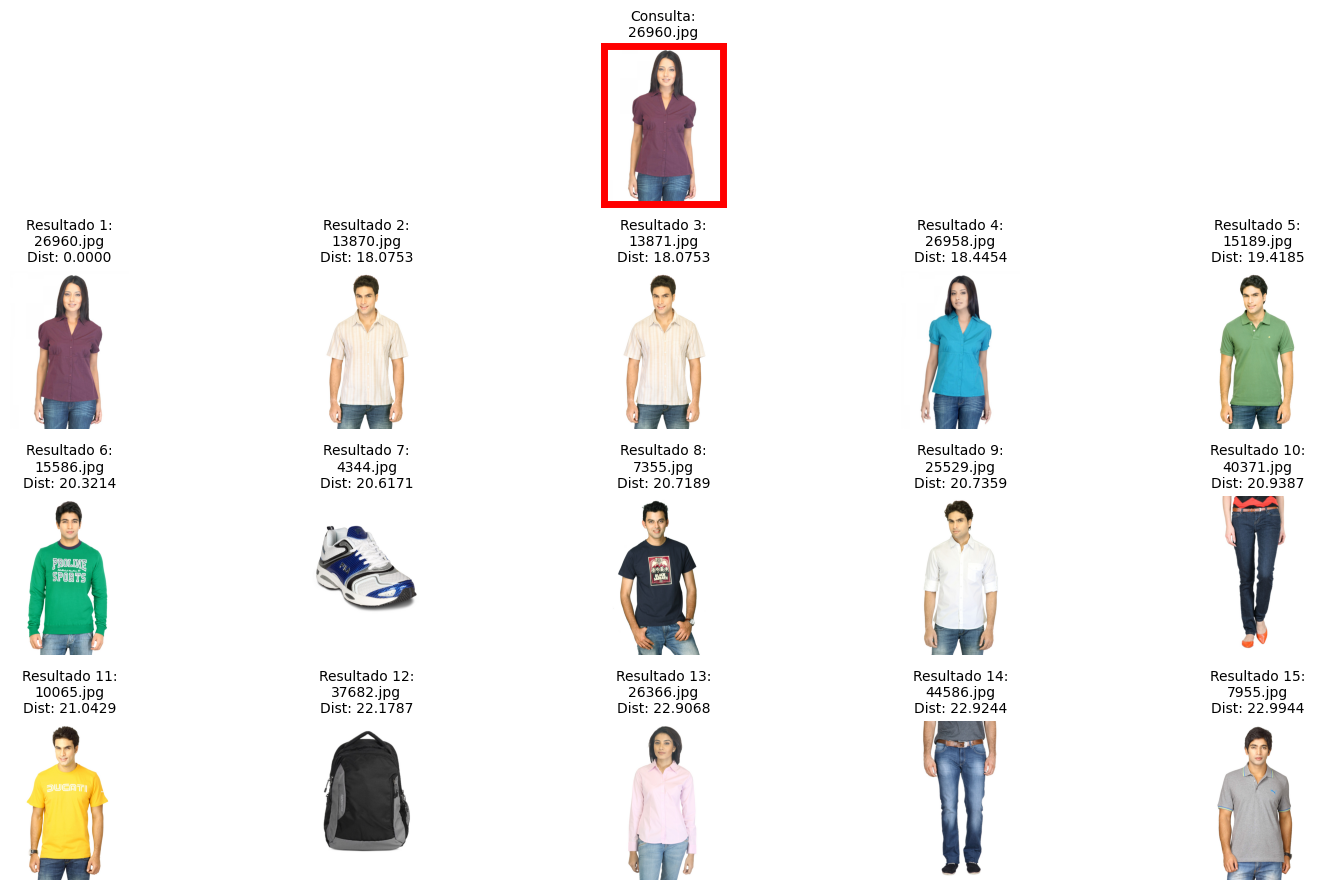

In [11]:
# Imagen aleatoria del dataset
random = np.random.randint(len(descriptors))
random = 7
print(random)
query_vector = descriptors[random]

idx = create_rtree_index(descriptors)
rtree_result = knn_rtree(query_vector, idx, descriptors, k=15)

print(idx)
print(rtree_result)

csv_file = "images.csv"
show_results(rtree_result, csv_file, random, 15)


